# Deep Learning CNN Regularization CIFAR-10

## Objective

This notebook explores the development and optimization of Convolutional Neural Networks (CNNs) for image classification on the CIFAR-10 dataset using TensorFlow and Keras. The primary objectives are to:

1. **Build and evaluate baseline CNN architectures** with varying depths and complexities
2. **Implement regularization techniques** including:
   - Batch Normalization for stabilizing training and improving convergence
   - Dropout layers to prevent overfitting
   - Data augmentation (random horizontal flips and Gaussian blur) to improve generalization
3. **Optimize model performance** through:
   - Different optimizer configurations (Adam and SGD with momentum)
   - Learning rate scheduling with ReduceLROnPlateau
   - Early stopping to prevent overfitting
4. **Compare model architectures** to understand the impact of depth, kernel sizes, and regularization on classification accuracy

The notebook systematically progresses from simple 2-layer CNNs to deeper 4-layer architectures, incorporating best practices in deep learning to achieve robust performance on the CIFAR-10 benchmark dataset.

## CIFAR-10 Dataset Classes

The CIFAR-10 dataset consists of 60,000 32×32 color images across 10 mutually exclusive classes:

| Class Index | Class Name |
|-------------|------------|
| 0 | Airplane |
| 1 | Automobile |
| 2 | Bird |
| 3 | Cat |
| 4 | Deer |
| 5 | Dog |
| 6 | Frog |
| 7 | Horse |
| 8 | Ship |
| 9 | Truck |

Each class contains 6,000 images, with 5,000 images in the training set and 1,000 images in the test set. The dataset is commonly used as a benchmark for image classification algorithms in computer vision and deep learning research.

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd 
import tensorflow as tf   
print(tf.__version__) 
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model

/Users/agirgis/Downloads/deep-learning-cnn-regularization-cifar10/venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


2.16.2


In [37]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.16.2
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [2]:
# SSL certificate bypass
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Data Exploration and Visualization

This section explores the CIFAR-10 dataset by creating a visual grid displaying sample images from each of the 10 classes. The visualization helps us understand the variety and characteristics of images in each category, providing insight into the classification task ahead.

The grid displays 5 randomly selected images per class, organized in rows with clear class labels, making it easy to see the diversity within each category and the challenges the model will face in distinguishing between similar objects.

In [3]:
(x_train,y_train), (x_test,y_test) =tf.keras.datasets.cifar10.load_data()

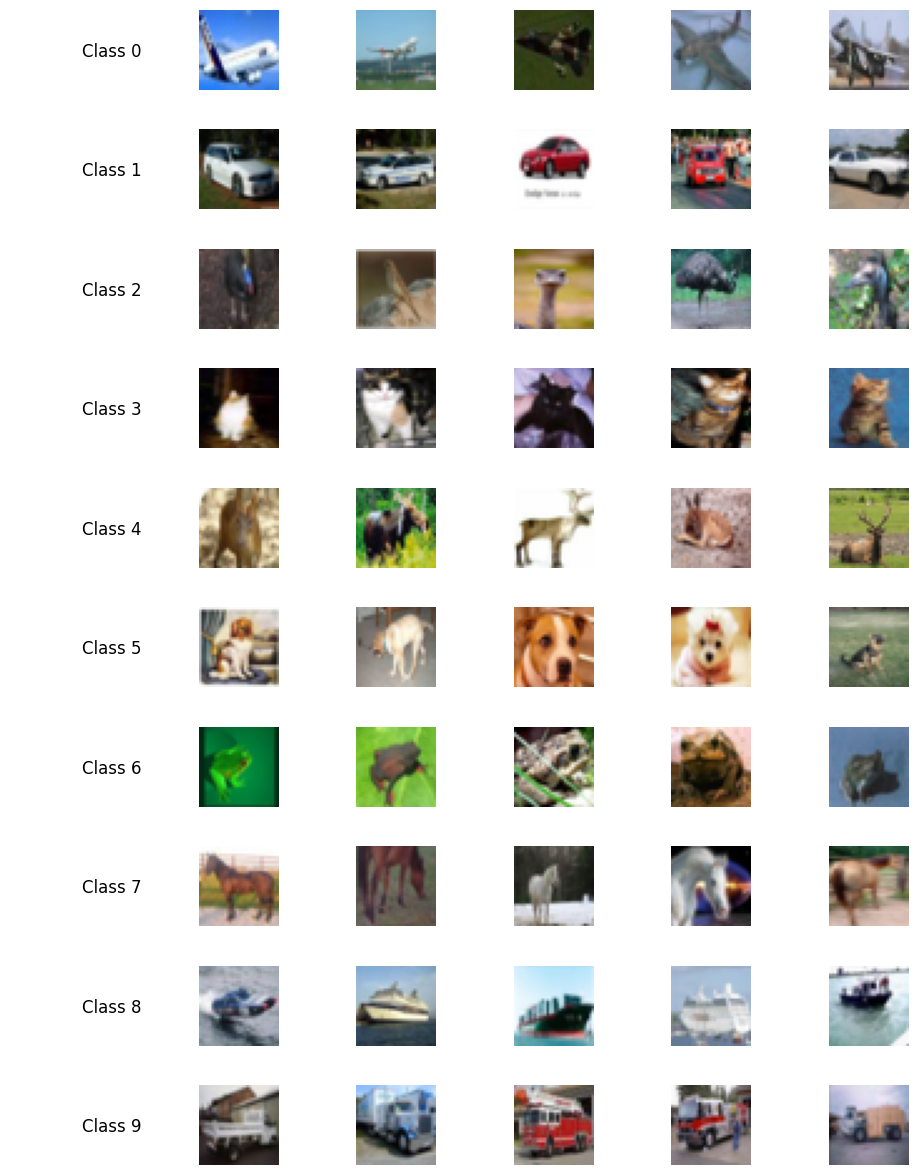

In [4]:
import random

# create a 10×5 grid with ten rows and five columns where each row randomly displays five images fromtherespectiveclass. Theoutputofyourcodehereshould bethisvisualizationwiththeclass label clearlypresentedonthe leftalong  withthefiveimagesneatlyorganizedasagrid 
# The first 10 images in the training set
K = len(set(y_train.flatten()))
fig, axes = plt.subplots(10, 6, figsize=(12, 15))
for i in range(10):
    axes[i][0].text(0.5, 0.5, f"Class {i}", verticalalignment='center_baseline', horizontalalignment='left', fontsize=12)
    axes[i][0].axis('off')
    class_indices = np.where(y_train.flatten() == i)[0]
    random_indices = random.sample(list(class_indices), 5)
    for j, idx in enumerate(random_indices):
        axes[i][j+1].imshow(x_train[idx])
        axes[i][j+1].axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.savefig('assets/cifar10_samples.png', dpi=300, bbox_inches='tight')
plt.show()


## Data Normalization

Proper data normalization is critical for neural network training stability and convergence. Here, we standardize the pixel intensities by mean-centering and dividing by the standard deviation for each color channel (R, G, B) independently.

**Important**: The normalization parameters (mean and standard deviation) are computed exclusively from the training set and then applied to both the training and test sets. This ensures that the test set remains truly independent and prevents data leakage that could artificially inflate performance metrics.

Each color channel is normalized separately to account for potential differences in intensity distributions across the RGB spectrum.

In [5]:
# Convert images to float32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# Normalize the data using the training set statistics
mean = np.mean(x_train, axis=(0, 1, 2))  # shape (3,) for CIFAR-10
std = np.std(x_train, axis=(0, 1, 2))    # shape (3,)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

## Train-Validation Split

The original training dataset is partitioned into separate training (80%) and validation (20%) sets. The validation set serves as an independent benchmark during training to monitor model performance and prevent overfitting through early stopping callbacks.

Since CIFAR-10 is already well-balanced with exactly 5,000 images per class, we use a simple random split without requiring stratification techniques.

In [6]:
# Partition the training dataset into separate training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)
print("x_val.shape:", x_val.shape)
print("y_val.shape:", y_val.shape)


x_train.shape: (40000, 32, 32, 3)
y_train.shape: (40000, 1)
x_val.shape: (10000, 32, 32, 3)
y_val.shape: (10000, 1)


## Baseline CNN Architecture

This section implements a foundational 2-layer convolutional neural network to establish baseline performance metrics. The architecture consists of:

**Convolutional Layers:**
- Two Conv2D layers with 32 filters each
- 3×3 kernel size with ReLU activation
- Max pooling (2×2) after each convolutional layer

**Fully Connected Layers:**
- Flatten operation to convert 2D feature maps to 1D vector
- Dense layer with 512 units and ReLU activation
- Output layer with 10 units (one per class) and softmax activation

This straightforward architecture serves as a reference point for evaluating the impact of additional depth and regularization techniques in subsequent experiments.

In [36]:
inputs = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

## Data Augmentation Pipeline

To improve model generalization and reduce overfitting, we implement a data augmentation pipeline that applies random transformations during training:

- **Random horizontal flips**: Mirrors images left-to-right with 50% probability
- **Gaussian blur**: Applies a 3×3 Gaussian blur kernel with 50% probability

These augmentations create variations of the training data, effectively expanding the dataset and helping the model learn more robust features that generalize better to unseen test images.

In [8]:
def random_gaussian_blur(image):
    p = tf.random.uniform([], 0, 1)
    
    def apply_blur():
        kernel = tf.constant([[1/16, 2/16, 1/16],
                              [2/16, 4/16, 2/16],
                              [1/16, 2/16, 1/16]], dtype=tf.float32)
        kernel = kernel[:, :, tf.newaxis, tf.newaxis]  # shape: (3, 3, 1, 1)
        kernel = tf.tile(kernel, multiples=[1, 1, 3, 1])
        image_expanded = tf.expand_dims(image, axis=0)  # shape: (1, H, W, 3)
        blurred = tf.nn.depthwise_conv2d(image_expanded, kernel, strides=[1, 1, 1, 1], padding='SAME')
        blurred = tf.squeeze(blurred, axis=0)
        return blurred
    
    return tf.cond(p < 0.5, apply_blur, lambda: image)

def augment(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = random_gaussian_blur(image)
    return image, label

batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=5000)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Model Training Configuration

The model is trained using:
- **Loss function**: Sparse categorical cross-entropy (suitable for multi-class classification)
- **Optimizer**: Adam with default parameters for efficient gradient descent
- **Early stopping**: Monitors validation loss with patience of 5 epochs, restoring the best weights to prevent overfitting
- **Batch size**: 32 samples per batch

This configuration ensures efficient training while maintaining model generalization through automatic early termination when validation performance plateaus.

In [9]:
model = Model(inputs, outputs)
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)
model.fit(train_ds,
          validation_data=val_ds,
          epochs=100,
          callbacks=[early_stopping])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,064,362 (4.06 MB)

 Trainable params: 1,064,362 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2026-01-01 13:33:14.990056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.4872 - loss: 1.4783 - val_accuracy: 0.5148 - val_loss: 1.6756
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.4872 - loss: 1.4783 - val_accuracy: 0.5148 - val_loss: 1.6756
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4707 - loss: 3.9442 - val_accuracy: 0.4633 - val_loss: 7.7260
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4707 - loss: 3.9442 - val_accuracy: 0.4633 - val_loss: 7.7260
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4090 - loss: 37.5200 - val_accuracy: 0.4084 - val_loss: 91.3061
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4090 - loss: 37.5200 - val_accuracy: 0.4084 - val_loss: 91.3061
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3958 - loss: 198.1233 - val_accuracy: 0.3969 - val_loss: 324.8003
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.39

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)


Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5846 - loss: 1.2723 - val_accuracy: 0.6014 - val_loss: 1.2393
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5846 - loss: 1.2723 - val_accuracy: 0.6014 - val_loss: 1.2393
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6054 - loss: 1.1755 - val_accuracy: 0.5997 - val_loss: 1.2811
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6054 - loss: 1.1755 - val_accuracy: 0.5997 - val_loss: 1.2811
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6004 - loss: 1.2386 - val_accuracy: 0.5445 - val_loss: 1.6433
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6004 - loss: 1.2386 - val_accuracy: 0.5445 - val_loss: 1.6433
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4635 - loss: 7.3631 - val_accuracy: 0.2378 - val_loss: 91.2919
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy:

## Training Performance Visualization

Plotting training and validation curves helps diagnose model performance, identify overfitting, and understand convergence behavior. The accuracy and loss curves provide visual feedback on how well the model learns and generalizes across epochs.

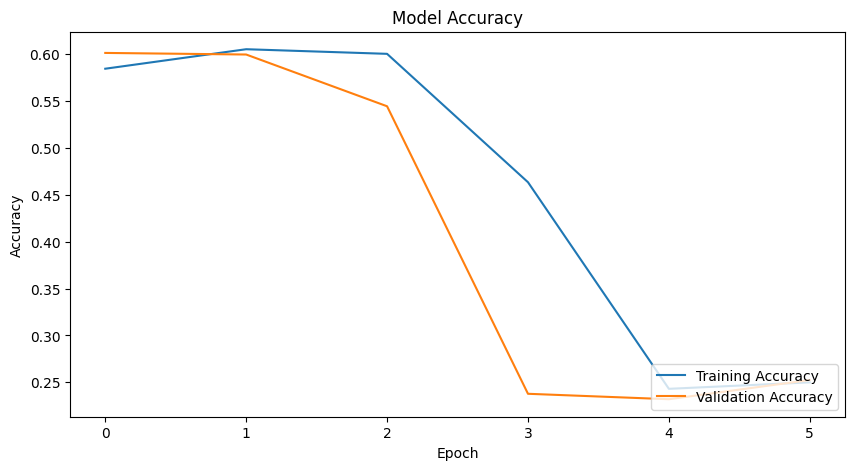

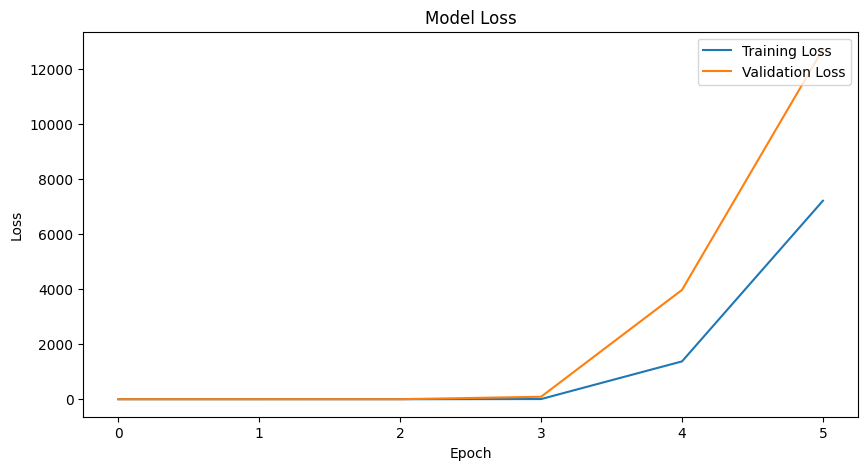

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [12]:
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(batch_size)  
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [13]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy of the best model: {:.2f}%".format(test_accuracy * 100))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6059 - loss: 1.2115
Test accuracy of the best model: 60.59%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6059 - loss: 1.2115
Test accuracy of the best model: 60.59%


## Deeper CNN Architecture (4-Layer)

Building upon the baseline model, this section explores the impact of increased network depth by adding two additional convolutional layers:

**Enhanced Architecture:**
- **First block**: 2 Conv2D layers (32 filters, 3×3) with max pooling
- **Second block**: 2 Conv2D layers (64 filters, 3×3) with max pooling
- **Fully connected**: Flatten → Dense(512) → Output(10)

**Hypothesis**: Deeper networks can learn more hierarchical and abstract feature representations, potentially improving classification accuracy. However, they also risk overfitting and may require more sophisticated regularization.

This experiment directly compares shallow vs. deep architectures to quantify the benefits and challenges of increased model capacity.

In [14]:
inputs = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,282 (790.16 KB)

 Trainable params: 202,282 (790.16 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)
model.fit(train_ds,
          validation_data=val_ds,
          epochs=100,
          callbacks=[early_stopping])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,282 (790.16 KB)

 Trainable params: 202,282 (790.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.4715 - loss: 1.4479 - val_accuracy: 0.5727 - val_loss: 1.2473
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.4715 - loss: 1.4479 - val_accuracy: 0.5727 - val_loss: 1.2473
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6034 - loss: 1.1163 - val_accuracy: 0.6310 - val_loss: 1.0654
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6034 - loss: 1.1163 - val_accuracy: 0.6310 - val_loss: 1.0654
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6457 - loss: 1.0145 - val_accuracy: 0.6292 - val_loss: 1.0818
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6457 - loss: 1.0145 - val_accuracy: 0.6292 - val_loss: 1.0818
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6480 - loss: 1.0466 - val_accuracy: 0.6141 - val_loss: 1.3009
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.6727 - loss: 0.9387 - val_accuracy: 0.6602 - val_loss: 1.0025
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.6727 - loss: 0.9387 - val_accuracy: 0.6602 - val_loss: 1.0025
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.6697 - loss: 0.9639 - val_accuracy: 0.6373 - val_loss: 1.0825
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.6697 - loss: 0.9639 - val_accuracy: 0.6373 - val_loss: 1.0825
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6402 - loss: 1.0726 - val_accuracy: 0.6158 - val_loss: 1.2675
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6402 - loss: 1.0726 - val_accuracy: 0.6158 - val_loss: 1.2675
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5789 - loss: 1.3727 - val_accuracy: 0.5400 - val_loss: 1.7331
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 

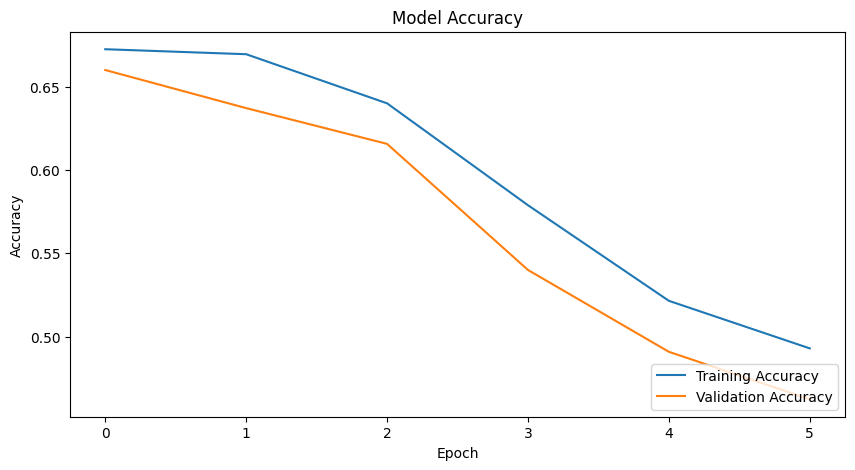

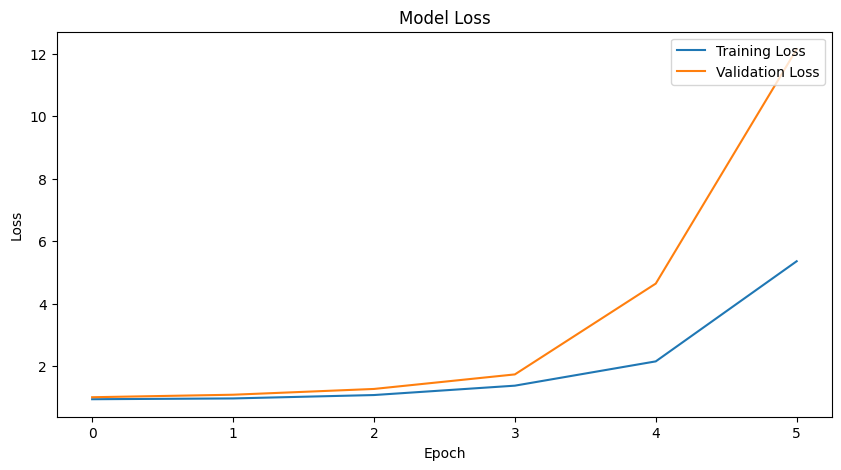

In [17]:

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [18]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy of the best model: {:.2f}%".format(test_accuracy * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6683 - loss: 0.9895
Test accuracy of the best model: 66.83%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6683 - loss: 0.9895
Test accuracy of the best model: 66.83%


## Batch Normalization Integration

Batch Normalization is a powerful technique that normalizes layer inputs, stabilizing and accelerating training. This section adds BatchNorm layers after every convolutional and fully connected layer (except the output).

**Key Benefits:**
- **Faster convergence**: Reduces internal covariate shift, allowing higher learning rates
- **Improved stability**: Normalizes activations, preventing vanishing/exploding gradients
- **Regularization effect**: Slight noise during training acts as implicit regularization

**Implementation Details:**
- BatchNorm applied after convolutions (before activation)
- `use_bias=False` in layers followed by BatchNorm (bias is redundant)
- Activation functions applied after normalization

This experiment demonstrates how BatchNorm impacts training dynamics, convergence speed, and final model performance.

In [19]:
inputs = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), padding='same', use_bias=False)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)  

x = Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)  

x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)  

x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x) 

x = Flatten()(x)
x = Dense(512, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 64)       │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 204,394 (798.41 KB)

 Trainable params: 202,986 (792.91 KB)

 Non-trainable params: 1,408 (5.50 KB)

In [20]:
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 64)       │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 204,394 (798.41 KB)

 Trainable params: 202,986 (792.91 KB)

 Non-trainable params: 1,408 (5.50 KB)

In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.5085 - loss: 1.3751 - val_accuracy: 0.5729 - val_loss: 1.2069
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.5085 - loss: 1.3751 - val_accuracy: 0.5729 - val_loss: 1.2069
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.6302 - loss: 1.0436 - val_accuracy: 0.6602 - val_loss: 0.9753
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.6302 - loss: 1.0436 - val_accuracy: 0.6602 - val_loss: 0.9753
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.6807 - loss: 0.9081 - val_accuracy: 0.6134 - val_loss: 1.1671
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.6807 - loss: 0.9081 - val_accuracy: 0.6134 - val_loss: 1.1671
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.7106 - loss: 0.8255 - val_accuracy: 0.6855 - val_loss: 0.9041
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 

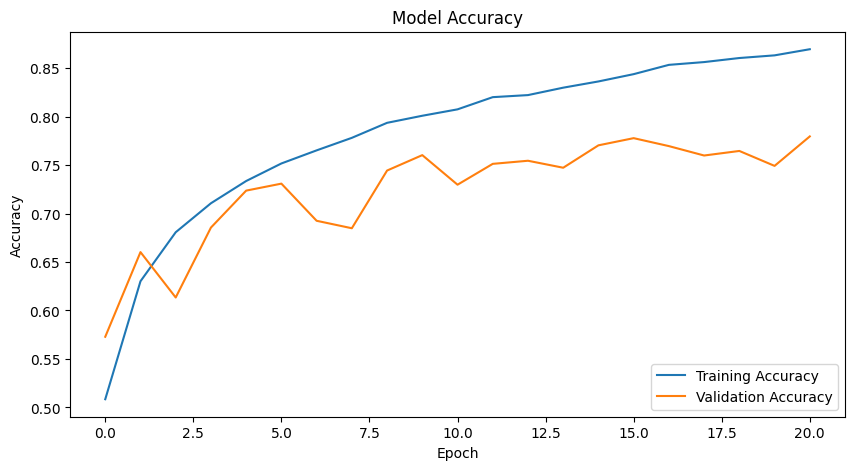

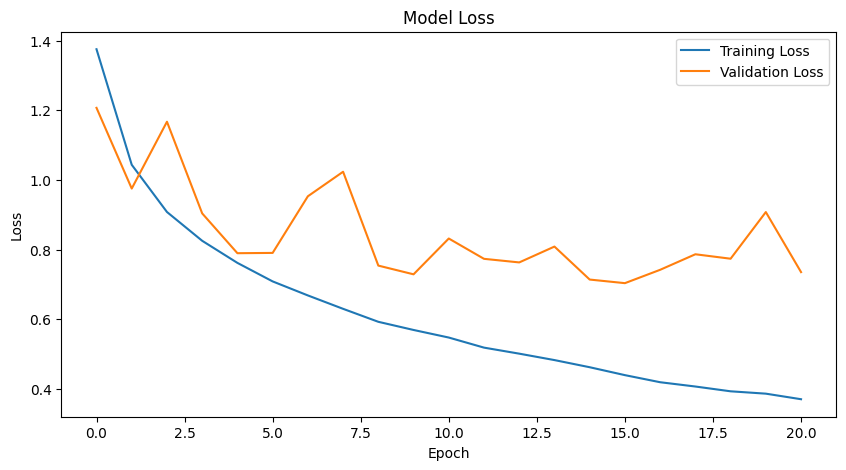

In [22]:

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [23]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy of the best model: {:.2f}%".format(test_accuracy * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7763 - loss: 0.7231
Test accuracy of the best model: 77.63%
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7763 - loss: 0.7231
Test accuracy of the best model: 77.63%


## Optimizer Experimentation: SGD with Momentum

This section explores alternative optimization strategies by replacing Adam with Stochastic Gradient Descent (SGD) enhanced with momentum and adaptive learning rate scheduling.

**Configuration:**
- **Optimizer**: SGD with momentum (β = 0.9) for improved convergence
- **Initial learning rate**: 0.01
- **Learning rate schedule**: ReduceLROnPlateau callback
  - Monitors validation loss
  - Reduces learning rate by factor of 0.1 when plateau detected
  - Patience of 3 epochs before reduction

**Objective**: Compare Adam's adaptive learning rates against SGD's simpler but potentially more generalizable optimization path. The learning rate scheduler helps SGD escape plateaus and fine-tune weights in later training stages.

In [24]:
# Define the SGD optimizer with momentum 0.9.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Compile the model using the SGD optimizer
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Define a learning rate schedule callback that reduces the learning rate when a plateau is detected
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                   factor=0.1,  
                                                   patience=3,  
                                                   verbose=1)

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10, # Reduce the number of epochs to 10, my computer is slow
          callbacks=[early_stopping, reduce_lr])


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.8357 - loss: 0.4659 - val_accuracy: 0.7632 - val_loss: 0.7503 - learning_rate: 0.0100
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.8357 - loss: 0.4659 - val_accuracy: 0.7632 - val_loss: 0.7503 - learning_rate: 0.0100
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.8565 - loss: 0.4047 - val_accuracy: 0.7775 - val_loss: 0.7112 - learning_rate: 0.0100
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.8565 - loss: 0.4047 - val_accuracy: 0.7775 - val_loss: 0.7112 - learning_rate: 0.0100
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8629 - loss: 0.3863 - val_accuracy: 0.7781 - val_loss: 0.7246 - learning_rate: 0.0100
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8629 - loss: 0.3863 - val_accuracy: 0.7781 - val_loss: 0.7246 - learning_rate: 0.0100
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accura

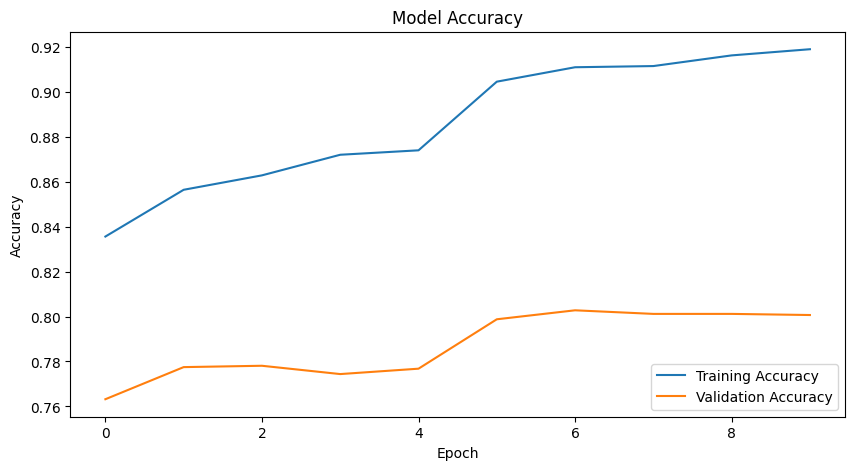

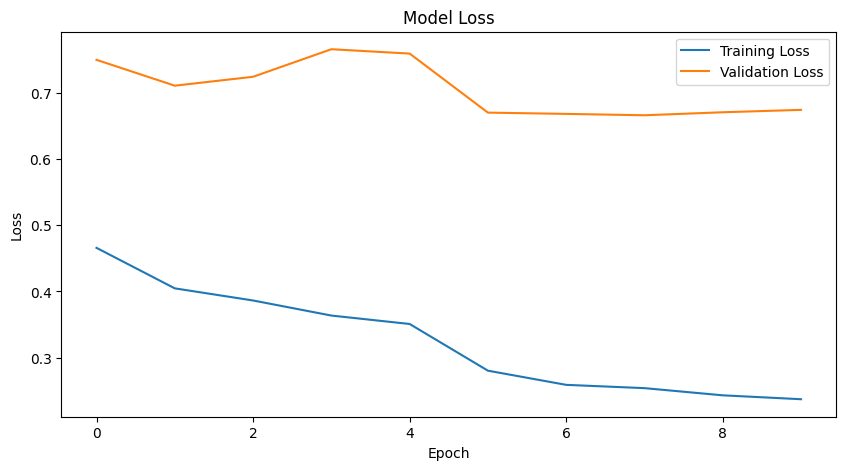

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [26]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy of the best model: {:.2f}%".format(test_accuracy * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7996 - loss: 0.6789
Test accuracy of the best model: 79.96%
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7996 - loss: 0.6789
Test accuracy of the best model: 79.96%


## Dropout Regularization

Dropout is a regularization technique that randomly deactivates neurons during training, forcing the network to learn more robust and redundant representations.

**Implementation:**
- Dropout layers added after fully connected layers (post-BatchNorm, pre-next layer)
- Dropout rate: 0.5 (50% of neurons randomly dropped during training)
- Applied only during training; deactivated during inference

**Expected Impact:**
- Reduces overfitting by preventing co-adaptation of neurons
- Improves generalization to test data
- May slightly slow convergence but yields better final performance

This experiment quantifies the regularization benefits of dropout when combined with batch normalization and SGD optimization.

In [27]:
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, 
                                     Activation, Flatten, Dense, Dropout)
from tensorflow.keras.models import Model
import tensorflow as tf

inputs = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), padding='same', use_bias=False)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)  

x = Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)  # 8x8x32

x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)  

x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)  

x = Flatten()(x)

x = Dense(512, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Added a Dropout layer.
dropout_rate = 0.5 
x = Dropout(dropout_rate)(x)

outputs = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs, outputs)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 64)       │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 4, 4, 64)       │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 204,394 (798.41 KB)

 Trainable params: 202,986 (792.91 KB)

 Non-trainable params: 1,408 (5.50 KB)

In [28]:
# Define the SGD optimizer with momentum 0.9.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Compile the model using the SGD optimizer
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Define a learning rate schedule callback that reduces the learning rate when a plateau is detected
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                   factor=0.1,  
                                                   patience=3,  
                                                   verbose=1)

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10, # Reduce the number of epochs to 10, my computer is slow
          callbacks=[early_stopping, reduce_lr])

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.4133 - loss: 1.7116 - val_accuracy: 0.5018 - val_loss: 1.3833 - learning_rate: 0.0100
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.4133 - loss: 1.7116 - val_accuracy: 0.5018 - val_loss: 1.3833 - learning_rate: 0.0100
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5484 - loss: 1.2842 - val_accuracy: 0.6220 - val_loss: 1.0768 - learning_rate: 0.0100
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5484 - loss: 1.2842 - val_accuracy: 0.6220 - val_loss: 1.0768 - learning_rate: 0.0100
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6092 - loss: 1.1021 - val_accuracy: 0.6658 - val_loss: 0.9490 - learning_rate: 0.0100
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6092 - loss: 1.1021 - val_accuracy: 0.6658 - val_loss: 0.9490 - learning_rate: 0.0100
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accura

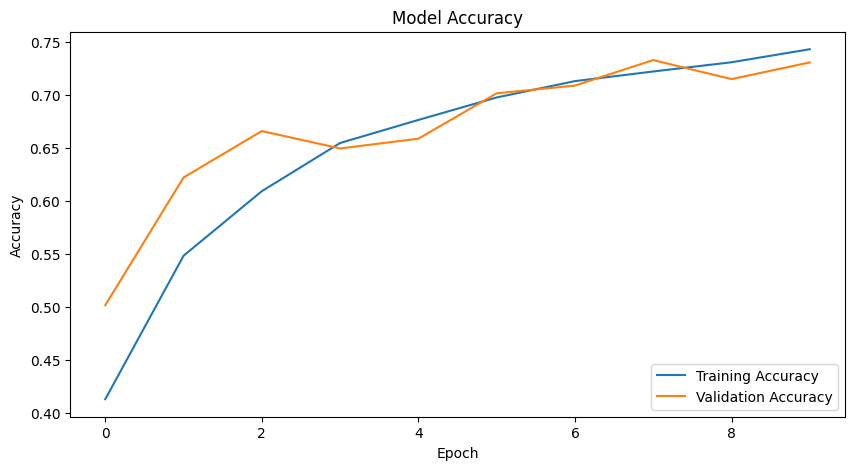

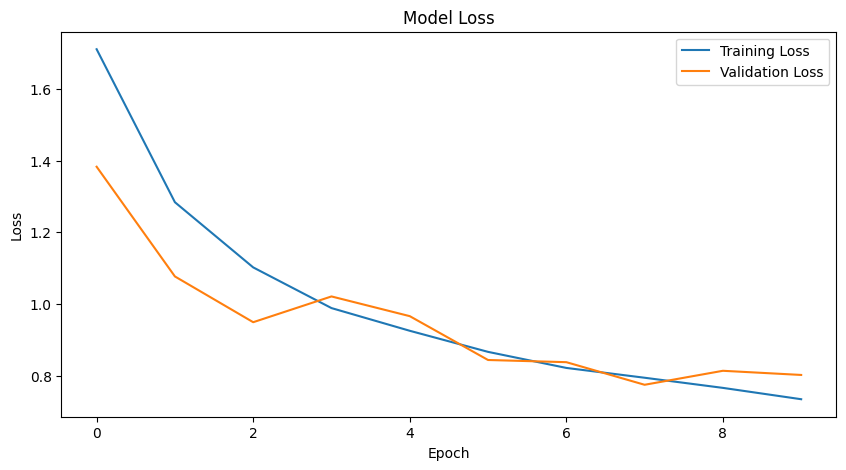

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [30]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy of the best model: {:.2f}%".format(test_accuracy * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7346 - loss: 0.7759
Test accuracy of the best model: 73.46%
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7346 - loss: 0.7759
Test accuracy of the best model: 73.46%


## Advanced Architecture Optimization

This final model incorporates architectural refinements to maximize performance by combining insights from previous experiments:

**Key Enhancements:**
1. **Variable kernel sizes**: 
   - 5×5 kernel in the first layer to capture broader spatial patterns
   - 3×3 kernels in subsequent layers for efficient feature extraction

2. **Comprehensive regularization stack**:
   - Batch Normalization throughout the network
   - Dropout (0.5) after fully connected layers
   - Data augmentation (horizontal flips, Gaussian blur)

3. **Optimized training**:
   - SGD with momentum (0.9)
   - Adaptive learning rate scheduling
   - Early stopping to prevent overfitting

**Design Philosophy**: Larger kernels early in the network capture global features, while smaller kernels in deeper layers extract fine-grained details. Combined with aggressive regularization, this architecture aims to achieve the best balance between model capacity and generalization.

This represents the final, most refined model incorporating all best practices discovered throughout the experimentation process.

In [31]:
# Input layer: images of size 32x32x3
inputs = Input(shape=(32, 32, 3))


# Use a 5x5 kernel initially.
x = Conv2D(32, (5, 5), padding='same', use_bias=False)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

# Switch to 3x3 kernels.
x = Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x) 

x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)  

x = Flatten()(x)

x = Dense(512, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Dropout layer after the fully connected block
dropout_rate = 0.5  
x = Dropout(dropout_rate)(x)

# Output layer: 10 classes using softmax.
outputs = Dense(10, activation='softmax')(x)

# Create the model.
model = Model(inputs, outputs)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 32)     │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 64)       │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 64)       │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 205,930 (804.41 KB)

 Trainable params: 204,522 (798.91 KB)

 Non-trainable params: 1,408 (5.50 KB)

In [32]:
# Define the SGD optimizer with momentum 0.9.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Compile the model using the SGD optimizer
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Define a learning rate schedule callback that reduces the learning rate when a plateau is detected
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                   factor=0.1,  
                                                   patience=3,  
                                                   verbose=1)

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10, # Reduce the number of epochs to 10, my computer is slow
          callbacks=[early_stopping, reduce_lr])

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.4150 - loss: 1.7003 - val_accuracy: 0.5146 - val_loss: 1.3658 - learning_rate: 0.0100
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.4150 - loss: 1.7003 - val_accuracy: 0.5146 - val_loss: 1.3658 - learning_rate: 0.0100
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5476 - loss: 1.2853 - val_accuracy: 0.6041 - val_loss: 1.1215 - learning_rate: 0.0100
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5476 - loss: 1.2853 - val_accuracy: 0.6041 - val_loss: 1.1215 - learning_rate: 0.0100
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.6165 - loss: 1.0889 - val_accuracy: 0.6588 - val_loss: 0.9832 - learning_rate: 0.0100
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.6165 - loss: 1.0889 - val_accuracy: 0.6588 - val_loss: 0.9832 - learning_rate: 0.0100
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accura

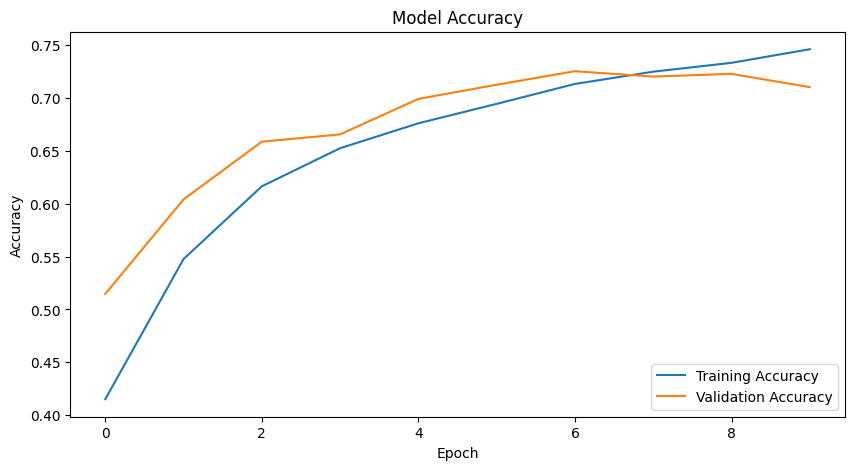

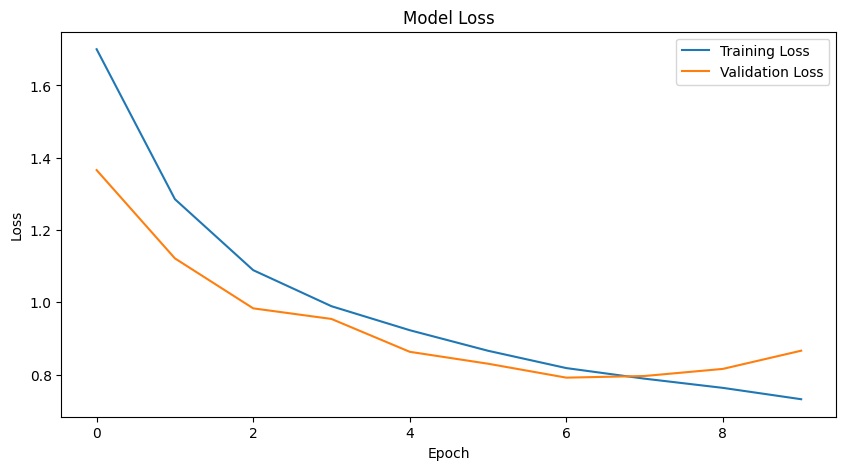

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('assets/best_model_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('assets/best_model_loss.png', dpi=300, bbox_inches='tight')
plt.show()


In [34]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy of the best model: {:.2f}%".format(test_accuracy * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7283 - loss: 0.7904
Test accuracy of the best model: 72.83%
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7283 - loss: 0.7904
Test accuracy of the best model: 72.83%


### Bonus: Plotting the misclassified images

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4494711..1.9318434].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4812206..2.126797].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9892114..1.9818428].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6742227..1.9794676].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.915813..1.9808707].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4812206..2.126797].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9892114..

Number of misclassified samples: 2717


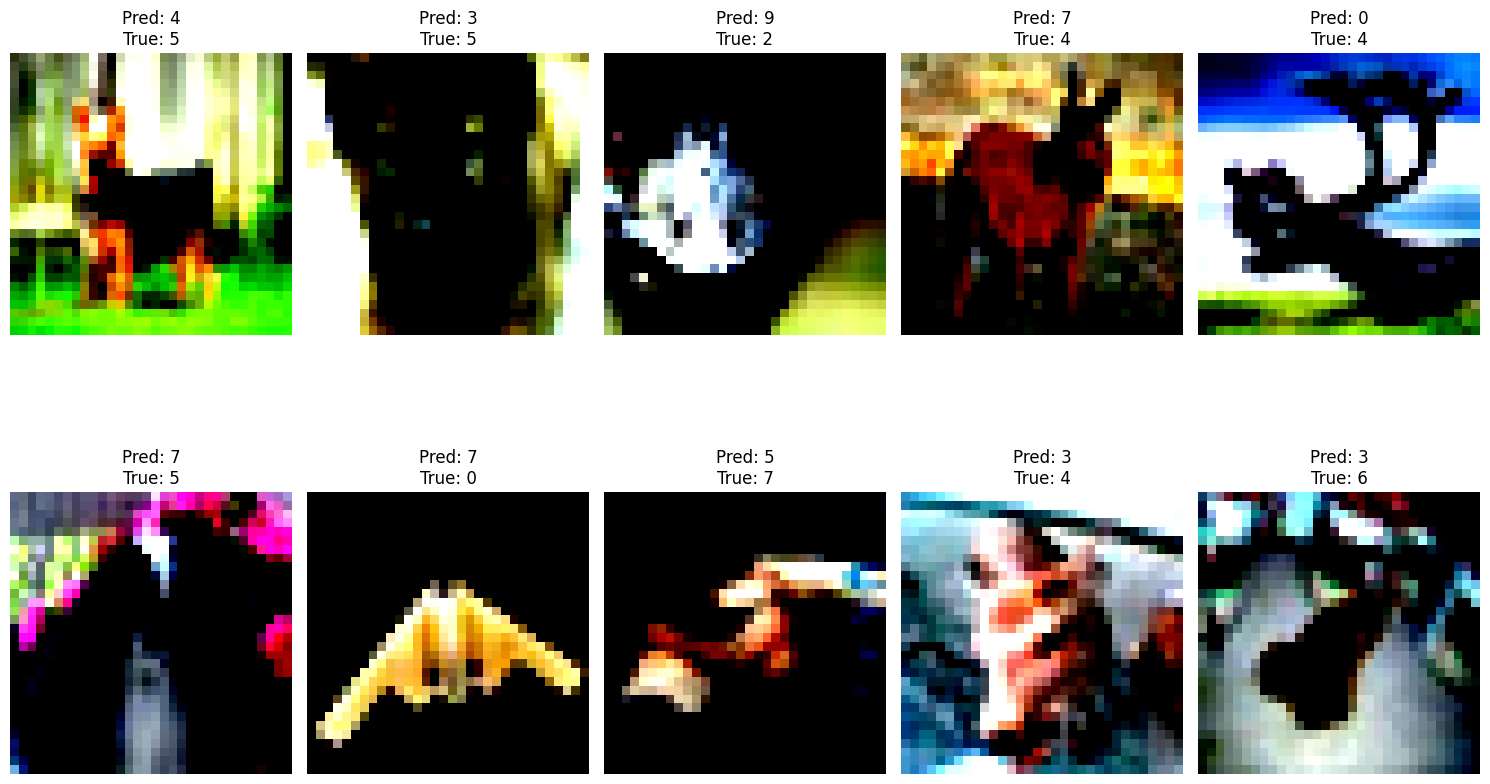

In [35]:
import numpy as np
import matplotlib.pyplot as plt

pred_probs = model.predict(x_test)
pred_labels = np.argmax(pred_probs, axis=1)


true_labels = y_test.flatten() # Flatten the true labels to 1D

# Identify the indices of misclassified images.
misclassified_indices = np.where(pred_labels != true_labels)[0]
print("Number of misclassified samples:", len(misclassified_indices))

num_to_plot = 10
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices[:num_to_plot]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx])
    plt.title(f"Pred: {pred_labels[idx]}\nTrue: {true_labels[idx]}")
    plt.axis("off")
plt.tight_layout()
plt.savefig('assets/misclassified_samples.png', dpi=300, bbox_inches='tight')
plt.show()
